# <font color = "brown"> ARMA </font>

## <font color = 'brown'> Importing Libraries </font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

## <font color = 'brown'> Read Data </font>

In [2]:
train = pd.read_excel("../training_data.xlsx")
train['Time (UTC+10)'] = pd.to_datetime(train['Time (UTC+10)'])
train.columns = ['time', 'NSW price', 'SA price', 'TAS price', 'VIC price', 'NSW supply', 'SA supply', 
                  'TAS supply', 'VIC supply', 'NSW demand', 'SA demand', 'TAS demand', 'VIC demand']
train.tail()

,time,NSW price,SA price,TAS price,VIC price,NSW supply,SA supply,TAS supply,VIC supply,NSW demand,SA demand,TAS demand,VIC demand
61291,2021-06-30 22:00:00,95.21,112.19,117.54,92.52,29.46,31.90,109.11,216.45,9214,1850,1332,5874
61292,2021-06-30 22:30:00,71.81,95.28,63.15,67.46,27.71,20.82,103.20,224.00,9022,1766,1289,5653
61293,2021-06-30 23:00:00,75.17,87.72,60.16,60.16,12.08,11.21,79.69,211.81,8804,1672,1269,5397
61294,2021-06-30 23:30:00,80.41,88.37,71.57,73.85,3.41,6.33,81.11,190.95,8654,1587,1231,5487
61295,2021-07-01 00:00:00,73.25,102.24,60.91,51.71,4.35,4.76,83.70,184.60,8521,1706,1197,5410


In [3]:
test = pd.read_excel("../testing_data.xlsx")
test['Time (UTC+10)'] = pd.to_datetime(test['Time (UTC+10)'])
test.columns = ['time', 'NSW price', 'SA price', 'TAS price', 'VIC price', 'NSW supply', 'SA supply', 
                  'TAS supply', 'VIC supply', 'NSW demand', 'SA demand', 'TAS demand', 'VIC demand']
test.tail()

,time,NSW price,SA price,TAS price,VIC price,NSW supply,SA supply,TAS supply,VIC supply,NSW demand,SA demand,TAS demand,VIC demand
2155,2021-08-14 22:00:00,50.84,59.16,7.54,49.93,8.74,36.42,154.69,182.52,8491,1718,1255,5492
2156,2021-08-14 22:30:00,66.85,80.01,10.52,62.86,7.52,51.83,156.09,206.23,8376,1665,1244,5344
2157,2021-08-14 23:00:00,55.64,77.76,7.63,32.26,7.69,42.04,160.30,215.20,8194,1614,1207,5204
2158,2021-08-14 23:30:00,52.25,76.47,7.52,25.10,8.35,38.04,167.00,226.95,8022,1573,1163,5268
2159,2021-08-15 00:00:00,48.69,83.68,23.87,8.73,8.07,47.47,156.92,251.75,7867,1680,1139,5244


### look at train dataframe

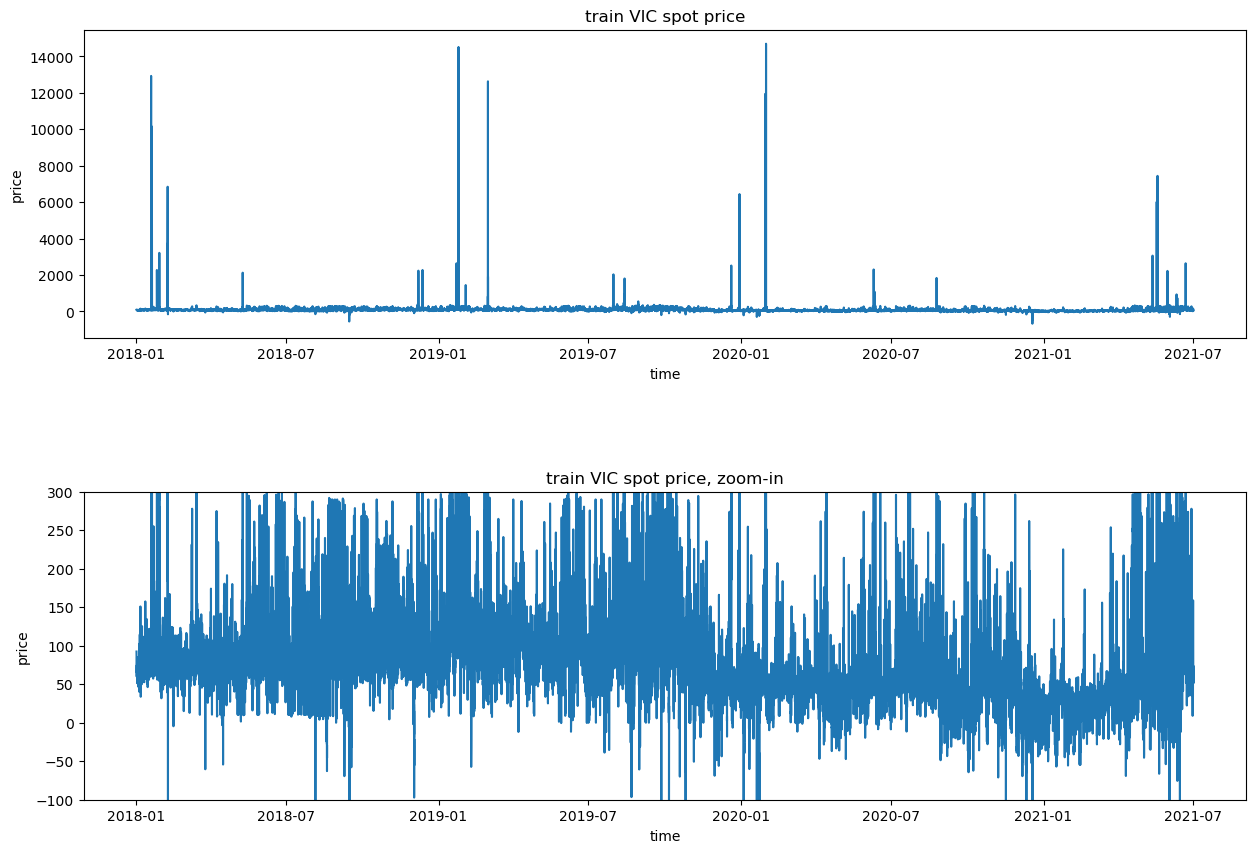

In [4]:
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.plot(train[['time']], train[['VIC price']])
plt.gca().set(title='train VIC spot price', xlabel='time', ylabel='price')

plt.subplot(212)
plt.plot(train[['time']], train[['VIC price']])
plt.gca().set(title='train VIC spot price, zoom-in', xlabel='time', ylabel='price')
plt.ylim(-100,300)

plt.subplots_adjust(hspace=0.5)
plt.show()

### test stationary to choose d

The augmented Dichey-Fuller test has null hypothesis H0 meaning data is not stationary. The test gives p-value=0.0, which is below the significant level(p=0.05), so we reject the null hypothesis, so Victoria price is a stationary time series. Then d=0 for the ARIMA model, thus ARIMA is actually ARMA.

In [5]:
result = adfuller(train['VIC price'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -25.002299898833005
p-value: 0.0
Critial Values:
   1%, -3.4304567929672247
Critial Values:
   5%, -2.861587200489141
Critial Values:
   10%, -2.5667951232260715


### ACF plot and PACF plot

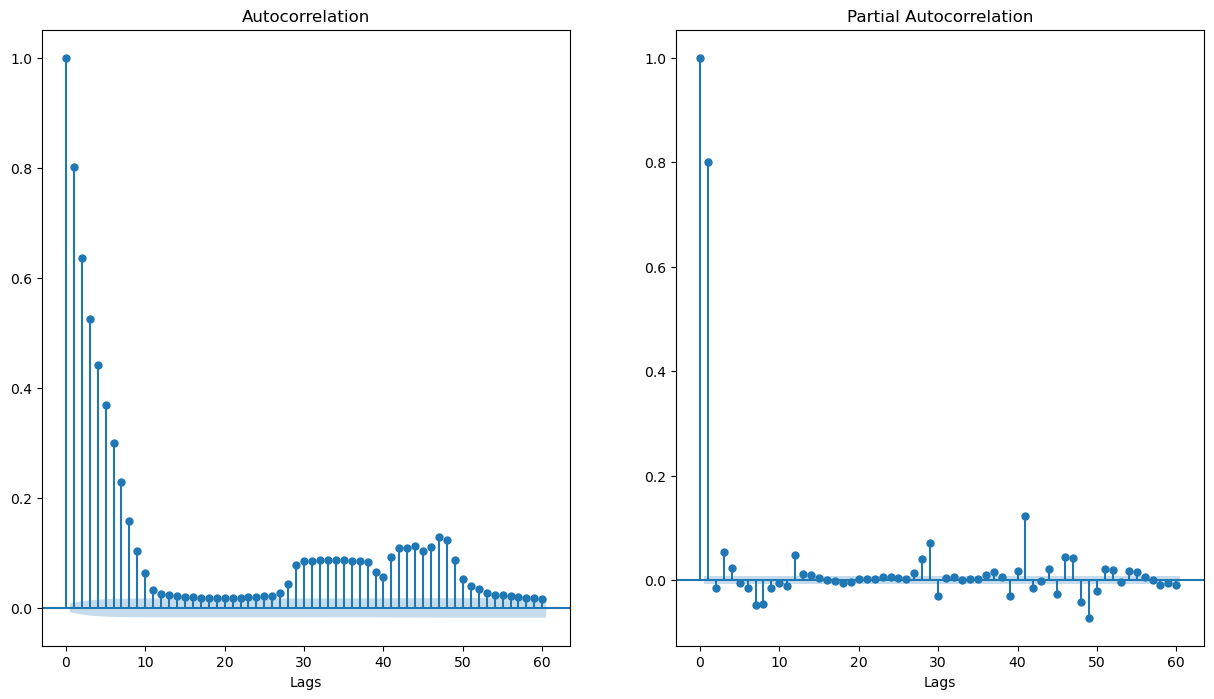

In [24]:
fig, axes = plt.subplots(1,2, figsize=(15,8))
plot_acf(train['VIC price'], lags=60, ax=axes[0])
axes[0].set_title('Autocorrelation')
axes[0].set_xlabel('Lags')
plot_pacf(train['VIC price'], lags=60, ax=axes[1])
axes[1].set_title('Partial Autocorrelation')
axes[1].set_xlabel('Lags')
plt.show()

Autocorrelation values decay exponentially-like in the ACF plot(left plot), regardless of the increasing values from around lags=30-50. If regardless of this rise, choose q=10, because autocorrelation values after lag=10 fall in the non-significant blue shaded area, which means values at these lags are not useful for prediction/regression. If taking in account of the rise and choose q=52, training time will be very long, so still choose q=10.

In the PACF plot, partial autocorrelation values have a sharp spike at lag=1, values after lag=1 drop to quite small values compared to value at lag=1, so choose p=1.

### ARMA model

In the statsmodels library, order parameters: p, d, q should be given as input when using an ARIMA model, in the form of order=(p,d,q).

#### choose order=(1,0,10)

In [7]:
# model training
model = ARIMA(train['VIC price'], order=(1, 0, 10))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              VIC price   No. Observations:                61296
Model:                ARIMA(1, 0, 10)   Log Likelihood             -403513.907
Date:                Thu, 14 Oct 2021   AIC                         807053.814
Time:                        21:22:50   BIC                         807171.119
Sample:                             0   HQIC                        807090.214
                              - 61296                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.7512      7.340     10.729      0.000      64.364      93.138
ar.L1          0.2637      0.007     38.697      0.000       0.250       0.277
ma.L1          0.5455      0.007     80.454      0.0

From the training summary, sigma2(variance for error terms) is very large because original data has quite large variance but small lag values are chosen. So for a more accurate prediction, train models with smaller amount of data every time a prediction is made.

In [8]:
# generate predictions for test period
history = list(train['VIC price'].values[-10:])
ltest = list(test['VIC price'].values)
testprediction = list()

for t in range(0,len(ltest)):
    model = ARIMA(history[-10:], order=(1,0,10))
    prediction = model.fit().forecast()[0]
    testprediction.append(prediction)
    history.append(ltest[t])

In [11]:
testprediction_df = pd.DataFrame(testprediction, index=test.index, columns=['Predicted Price'])
testprediction_df.insert(0, 'Time (UTC+10)', test['time'])
testprediction_df

,Time (UTC+10),Predicted Price
0,2021-07-01 00:30:00,79.544752
1,2021-07-01 01:00:00,87.232014
2,2021-07-01 01:30:00,67.978892
3,2021-07-01 02:00:00,83.347320
4,2021-07-01 02:30:00,79.341725
...,...,...
2155,2021-08-14 22:00:00,120.369142
2156,2021-08-14 22:30:00,108.510558
2157,2021-08-14 23:00:00,85.123126
2158,2021-08-14 23:30:00,45.348283


In [12]:
# export test predictions to excel
testprediction_df.to_excel("ARIMA_predictions.xlsx", index=False)

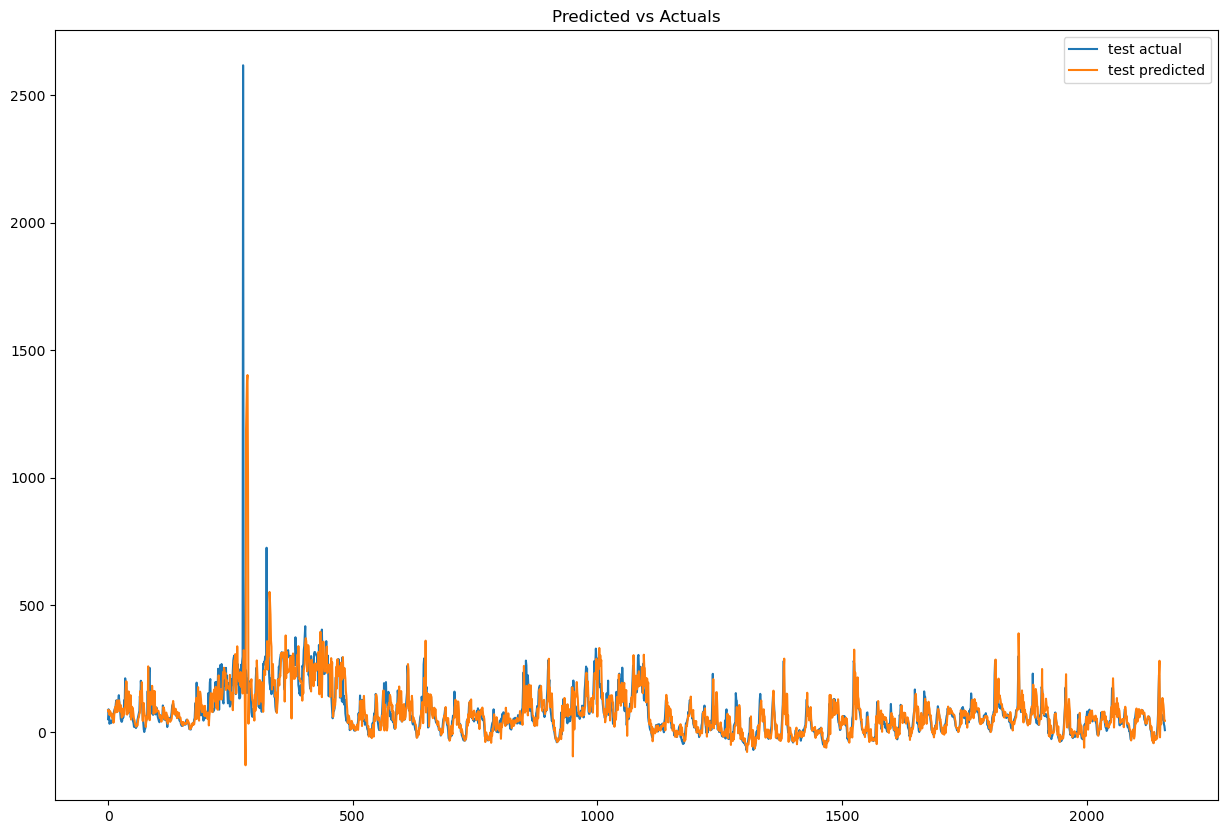

In [13]:
# visualise
plt.figure(figsize=(15,10))
plt.plot(test['VIC price'], label='test actual')
plt.plot(testprediction_df['Predicted Price'], label='test predicted')
plt.title('Predicted vs Actuals')
plt.legend()
plt.savefig("../../plots/ARMA.png")
plt.show()

## <font color = 'brown'> Calculate Metrics </font>
To evaluate performance, the metrics used are:

1. Mean Absolute Percentage Error (MAPE)
$\\ \dfrac{100\%}{n}\sum\limits_{t=1}^{n}\left |\frac{e_t}{y_t}\right|$


2. Root-Mean-Square Error (RMSE)
$\\ \sqrt{\dfrac{1}{n}\sum\limits_{t=1}^{n}e_t^2}$ 


3. Mean Absolute Error (MAE)
$\\ \dfrac{1}{n}\sum\limits_{t=1}^{n}|e_t|$

where $e_t$ is $Y_{predicted} - Y_{actual}$

In [14]:
# Define metrics
# Cited from https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd, https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
rmse = np.sqrt(mean_squared_error(test['VIC price'].values, testprediction_df['Predicted Price'].values))
mae = mean_absolute_error(test['VIC price'].values, testprediction_df['Predicted Price'].values)
mape = mean_absolute_percentage_error(test['VIC price'].values, testprediction_df['Predicted Price'].values)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('MAPE: ', mape)

RMSE:  88.27324995977355
MAE:  36.98520408602382
MAPE:  171.36634621457108
